## Проект 6

## Предсказание биологического ответа молекул

In [3]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

%matplotlib inline
plt.style.use('seaborn')

C:\Users\Администратор\AppData\Local\Temp\ipykernel_1948\1055135546.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
# загружаю данные
data = pd.read_csv('_train_sem09 (1).csv')

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

In [5]:
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


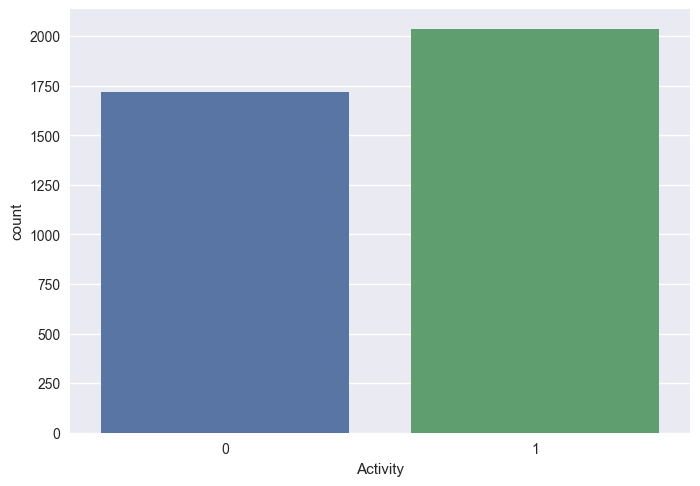

In [6]:
# проверю сбалансированность классов
sns.countplot(data=data, x='Activity');

Данные близки к балансу, всё равно буду использовать стратификационное разбиение выборок

In [7]:
# создаю матрицу наблюдений Х и вектор правильных ответов y
X = data.drop(['Activity'], axis=1)
y = data['Activity']

# разделяю выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

# Логистическая регрессия

In [6]:
# создаю объект логистической регрессии
logistic_reg = linear_model.LogisticRegression(random_state=42)

# обучаю модель
logistic_reg.fit(X_train, y_train)

# делаю предсказание
log_pred_train = logistic_reg.predict(X_train)
log_pred_test = logistic_reg.predict(X_test)

print('Метрика F1 на тестовой выборке ', metrics.f1_score(y_test, log_pred_test).round(2))

Метрика F1 на тестовой выборке  0.78


c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV

In [8]:
# задаю параметры
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}]

# использую метод
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
grid_search.fit(X_train, y_train) 

# вывожу метрику
y_test_pred = grid_search.predict(X_test)
print('Метрика F1 на тестовой выборке ', metrics.f1_score(y_test, y_test_pred).round(2))
print('Наилучшие значения гиперпараметров: ', grid_search.best_params_)

Метрика F1 на тестовой выборке  0.79
Наилучшие значения гиперпараметров:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


RandomizedSearchCV

In [9]:
# задаю параметры
param_distributions = [{'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}]

# использую метод           
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
random_search.fit(X_train, y_train) 

# вывожу метрику
y_test_pred = random_search.predict(X_test)
print('Метрика F1 на тестовой выборке ',metrics.f1_score(y_test, y_test_pred).round(2))
print('Наилучшие значения гиперпараметров: ', random_search.best_params_)

Метрика F1 на тестовой выборке  0.78
Наилучшие значения гиперпараметров:  {'solver': 'sag', 'penalty': 'l2', 'C': 0.23}


Hyperopt

In [10]:
# задаю пространство поиска гиперпараметров
space={'penalty': hp.choice('penalty', ['l1', 'l2']),
       'solver' : hp.choice('solver', ['liblinear', 'saga']),
       'C': hp.uniform('C', 0.01, 1)
      }


random_state = 42
def hyperopt(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # обучаею модель
    model.fit(X, y)
    # применю  cross validation 
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

#подбор гиперпараметров

trials = Trials()

best=fmin(hyperopt, # функция 
          space=space, # пространство гиперпараметров
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best))


TPE is being used as the default algorithm.


  5%|▌         | 1/20 [00:02<00:40,  2.12s/trial, best loss: -0.7706169946428503]

c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 15%|█▌        | 3/20 [00:13<01:12,  4.25s/trial, best loss: -0.7807204491271118]

c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 25%|██▌       | 5/20 [00:23<01:03,  4.27s/trial, best loss: -0.7826782883390004]

c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███       | 6/20 [00:30<01:12,  5.19s/trial, best loss: -0.7826782883390004]

c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 45%|████▌     | 9/20 [00:39<00:36,  3.32s/trial, best loss: -0.7826782883390004]

c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 55%|█████▌    | 11/20 [00:50<00:34,  3.82s/trial, best loss: -0.7826782883390004]

c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 65%|██████▌   | 13/20 [00:58<00:25,  3.69s/trial, best loss: -0.7826782883390004]

c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|███████   | 14/20 [01:07<00:32,  5.49s/trial, best loss: -0.7826782883390004]

c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 16/20 [01:18<00:20,  5.08s/trial, best loss: -0.7826782883390004]

c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 85%|████████▌ | 17/20 [01:25<00:17,  5.67s/trial, best loss: -0.7826782883390004]

c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 18/20 [01:34<00:13,  6.60s/trial, best loss: -0.7843573900686336]

c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 20/20 [01:45<00:00,  5.28s/trial, best loss: -0.7843573900686336]
Наилучшие значения гиперпараметров {'C': 0.11205124547519595, 'penalty': 0, 'solver': 1}


In [11]:
# обучаю модель
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty= 'l1',
    solver= 'saga',
    C= 0.11)
model.fit(X_train, y_train)

#вывожу метрики
y_test_pred = model.predict(X_test)
print('Метрика f1 на тестовом наборе: ', metrics.f1_score(y_test, y_test_pred).round(2))

Метрика f1 на тестовом наборе:  0.79


c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optuna


In [12]:
def optuna_rf(trial):
  # задаю пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C', low=0.01, high=1)

  # создаю модель
  model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty = penalty,
    solver = solver,
    C = C)
  # обучаю модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

# cоздаю объект исследования
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищу лучшую комбинацию гиперпараметров
study.optimize(optuna_rf, n_trials=20)

[I 2023-10-09 13:12:58,133] A new study created in memory with name: LogisticRegression
c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-10-09 13:13:03,154] Trial 0 finished with value: 0.8548828719196836 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.8722083664145229}. Best is trial 0 with value: 0.8548828719196836.
c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-10-09 13:13:07,833] Trial 1 finished with value: 0.8150602409638554 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.19537475283489095}. Best is trial 0 with value: 0.8548828719196836.
c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-pac

In [13]:
#результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))


Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9968439214898408}


In [14]:
#обучаю модель и вывожу метрику
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('Метрика f1 на тестовом наборе: ', metrics.f1_score(y_test, y_test_pred).round(2))

Метрика f1 на тестовом наборе:  0.78


Выводы для модели логистической регрессии:

Метрики F1:

Модель с параметрами по умолчанию - 0.78

GridSearchCV - 0.79 (лучший результат)

RandomizedSearchCV - 0.78

Hyperopt - 0.79 (лучший результат)

Optuna - 0.78


# Случайный лес

In [15]:
#Создаю объект случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаю модель
rf.fit(X_train, y_train)

#Вывожу значения метрики 
y_test_pred = rf.predict(X_test)
print('Метрика f1 на тестовом наборе: ',metrics.f1_score(y_test, y_test_pred).round(2))

Метрика f1 на тестовом наборе:  0.81


GridSearchCV

In [16]:
# задаю параметры
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25]
              }
# использую метод            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
grid_search_forest.fit(X_train, y_train) 

# вывожу метрику
y_test_pred = grid_search_forest.predict(X_test)
print('Метрика f1 на тестовом наборе: ', metrics.f1_score(y_test, y_test_pred).round(2))
print('Наилучшие значения гиперпараметров: ', grid_search_forest.best_params_)

Метрика f1 на тестовом наборе:  0.82
Наилучшие значения гиперпараметров:  {'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 130}


RandomizedSearchCV

In [17]:
# задаю параметры
param_distributions = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25]
              }

# использую метод            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
random_search_forest.fit(X_train, y_train) 

# вывожу метрики
y_test_pred = random_search_forest.predict(X_test)
print('Метрика f1 на тестовом наборе: ', metrics.f1_score(y_test, y_test_pred).round(2))
print('Наилучшие значения гиперпараметров: ',random_search_forest.best_params_)

Метрика f1 на тестовом наборе:  0.82
Наилучшие значения гиперпараметров:  {'n_estimators': 160, 'min_samples_leaf': 5, 'max_depth': 20}


Hyreport

In [18]:
# задаю пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', low=100, high=300, q = 1),
       'max_depth' : hp.quniform('max_depth', low=15, high=40,q =  1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', low=3, high=7, q = 1)
      }

random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }  
    # обучаю модель
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    # применяю кросс-валидацию
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

In [19]:
# начинаю подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print('Наилучшие значения гиперпараметров', best)

100%|██████████| 20/20 [00:51<00:00,  2.60s/trial, best loss: -0.8089126500268057]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 3.0, 'n_estimators': 201.0}


In [21]:
# метрика
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
print('Метрика f1 на тестовом наборе: ', metrics.f1_score(y_test, y_test_pred).round(2))

Метрика f1 на тестовом наборе:  0.83


Optuna

In [22]:
def optuna_rf(trial):
  # задаю пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаю модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаю модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

# cоздаю объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищу лучшую комбинацию гиперпараметров
study.optimize(optuna_rf, n_trials=20)

[I 2023-10-09 13:21:45,845] A new study created in memory with name: RandomForestClassifier
[I 2023-10-09 13:21:47,234] Trial 0 finished with value: 0.8995713410900184 and parameters: {'n_estimators': 118, 'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8995713410900184.
[I 2023-10-09 13:21:49,101] Trial 1 finished with value: 0.9437308868501528 and parameters: {'n_estimators': 133, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9437308868501528.
[I 2023-10-09 13:21:51,215] Trial 2 finished with value: 0.9758335882532885 and parameters: {'n_estimators': 130, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9758335882532885.
[I 2023-10-09 13:21:54,096] Trial 3 finished with value: 0.9917254060680356 and parameters: {'n_estimators': 161, 'max_depth': 23, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9917254060680356.
[I 2023-10-09 13:21:56,347] Trial 4 finished with value: 0.9008844159804817 and parameters: {'n

In [26]:
# результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

Наилучшие значения гиперпараметров {'n_estimators': 174, 'max_depth': 30, 'min_samples_leaf': 2}


In [25]:
# результаты для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)


y_test_pred = model.predict(X_test)
print('Метрика f1 на тестовом наборе: ', metrics.f1_score(y_test, y_test_pred).round(2))

Метрика f1 на тестовом наборе:  0.82


Выводы для модели случайного леса

Метрики F1:

Модель с параметрами по умолчанию - 0.81

GridSearchCV - 0.82

RandomizedSearchCV - 0.82

Hyperopt - 0.83 (лучший результат)

Optuna - 0.82

#### Вывод проекта

#### Наилучший подбор гиперпараметров удалось зафиксировать у модели случайного леса методом Hyperopt.

#### Наилучшие значения гиперпараметров данного проекта {'max_depth': 22.0, 'min_samples_leaf': 3.0, 'n_estimators': 201.0}.